## IML_Projet_6
Classez des images à l'aide d'algorithmes de Deep Learning

This notebooks contains : 
- Data Augmentation to improve my  personal best model

In [0]:
# See if any TPUs are available for use:
# https://hackernoon.com/training-your-models-on-cloud-tpus-in-4-easy-steps-on-google-colab-u2ec3wiw

import os
import pprint
import tensorflow as tf
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)
except:
  pass


In [0]:
# Initialising a Distributed Training Strategy
resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: 10.58.99.226:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.58.99.226:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6395497289732447189)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 15212468252549262989)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9337737445597493005)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 947025731448038900)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device

## Data mount drive folder

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs

/content/drive/My Drive/OpenClassRooms/IML_Projet_6/code/DeepLearningPictureDogs


In [0]:
!ls

01_OC_IML_Project_6_explorations.ipynb
02_OC_IML_Project_6_my_neural_network.ipynb
03_OC_IML_Project_6_my_neural_network_2.ipynb
03_OC_IML_Project_6_my_neural_network_2_save01.ipynb
03_OC_IML_Project_6_my_neural_network_2_save02.ipynb
04_OC_IML_Project_6_10breeds.ipynb
05_OC_IML_Project_6_3breeds.ipynb
06_OC_IML_Project_6_3breeds_ResNet50.ipynb
07_OC_IML_Project_6_10breeds_ResNet50.ipynb
08_OC_IML_Project_6_my_neural_network_DAugm_01.ipynb
my_utils_dogs.py
__pycache__
README.md


## Import

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import os

import re

import pickle

import time

from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 25)

import scipy.io as sio

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
import cv2 as cv

import tensorflow
print(tensorflow.__version__)

# keras from scratch
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import load_model
# keras already trained
from keras.applications.vgg16 import VGG16
# keras image preparation
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
# decode prediction
from keras.applications.vgg16 import decode_predictions
# for training keras model : optimizers
from keras import optimizers
# Keras model base
from keras.models import Model

import json

# ne marche pas (une modif d'une fonction d'un module ne se répercute pas)
# import user module
#from my_utils_dogs import find_breed

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


1.15.0


Using TensorFlow backend.


## Definitions

In [0]:
path_data = '/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/'
path_file_list = 'lists/file_list.mat'
path_test_list = 'lists/test_list.mat'
path_train_list = 'lists/train_list.mat'
path_test_data = 'test_data.mat'
path_train_data = 'train_data.mat'

paths_images_all_breeds = ['Images/n02107683-Bernese_mountain_dog/',
                     'Images/n02088094-Afghan_hound/',
                     'Images/n02096051-Airedale/',
                     'Images/n02090721-Irish_wolfhound/',
                     'Images/n02091831-Saluki/',
                     'Images/n02092002-Scottish_deerhound/',
                     'Images/n02096294-Australian_terrier/',
                     'Images/n02095889-Sealyham_terrier/',
                     'Images/n02095570-Lakeland_terrier/',
                     'Images/n02110185-Siberian_husky/']

nb_breeds = 3
paths_images_breeds = paths_images_all_breeds[:nb_breeds]

path_img_test = path_data + 'Images/n02085620-Chihuahua/' + "n02085620_242.jpg"

path_df_dogs = path_data + 'df_dogs.pkl'
path_X_images = path_data + 'X_images.pkl'
path_Y_images = path_data + 'Y_images.pkl'

name_new_model_2 = 'VGG16_TL_class_01'
path_model_2 = path_data +  name_new_model_2 + '.pkl'

path_df_results = path_data + 'df_results.pkl'

path_imagenet = path_data + 'Images/imagenet_class_index.json'

train_percent = 0.7

## Useful functions

In [0]:
def import_data(paths_images_breeds, train_percent=0.7, force_import=False,
                path_df_dogs=path_df_dogs, path_X_images=path_X_images,
                path_train_list=None):
  '''
  Import data from images on disk

  3 possibilites if force_import = False:
  (1) no data on disk, no data in memory :
    - create df_dogs & X from image files 
    - separate train / test set for df_dogs
  (2) data pickled on disk, no data in memory : 
    - load data from pickled files for df_dogs & X
    - separate train / test set for df_dogs
  (3) data in memory
    - use df_dogs & X from memory 
    - separate train / test set for df_dogs
    - save df_dogs & X on disk
  
  if force_import = True, only  read from image files (1) is possible.

  example: import from memory or already pickled files on disk, with 70% train: 
    df_dogs, X, dict_breed = import_data(paths_images_breeds)
  
  '''
  # import from already processed pickle files on disk
  try:
    if force_import == False:
      df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
      #df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)
      return df_dogs, X, dict_breed 
  except:
    # if not in memory and not on disk
    pass # continue with importation from images files on disk
  

  # import from image files on disk
  df_dogs = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                  'Train'])
  # read images in source folders
  X=None
  for id, path_curr in enumerate(paths_images_breeds):
    breed_curr = re.findall('\w+(?=/$)', path_curr)
    print(breed_curr)
    for filename in os.listdir(path_data + path_curr):
      df_add = pd.DataFrame(columns=["filename", "path", "breed", "class", 
                                     "Train"], 
                          index =[0])
      df_add["filename"] = filename
      df_add["path"] = path_data + path_curr + filename
      df_add["breed"] = breed_curr
      df_add["class"] = id
      df_dogs = df_dogs.append(df_add, ignore_index=True)
      # create X image matrix
      img = load_img(df_add["path"].values[0], 
               target_size=(224, 224))  # Charger l'image
      img = img_to_array(img)  # Convertir en tableau numpy
      if X is None:
        X = img[np.newaxis, :]
      X = np.concatenate((X, img[np.newaxis, :]), axis=0)

  # seperate train/test 
  # check test/train mode
  if path_train_list is not None:
    print('Train/Test separation by mat')
    mat_train = sio.loadmat(path_data + path_train_list)
    df_train = pd.DataFrame(data=mat_train["file_list"], 
                           columns=["filename_brut"])
    df_train["filename"] = df_train["filename_brut"].apply(apply_find_filename)
    df_dogs["Train"] = df_dogs["filename"].apply(check_file_train, 
                                                 args=(df_train,))
  else:
    print('Train/Test separation by percent')
    df_dogs = separate_train_by_class(df_dogs, train_percent=train_percent)   
  # preprocess image data for VGG-16
  X = preprocess_input(X)

  # find breed name
  dict_breed = dict()
  for id_class in df_dogs["class"].unique(): 
    dict_breed[id_class] = df_dogs[df_dogs["class"] == \
                                 id_class]["breed"].values[0]
  
  # save on disk
  save_data(df_dogs, path_df_dogs, X, path_X_images)

  return df_dogs, X, dict_breed

def check_file_train(filename, df_train):
  '''
  Apply function for dataFrame column to check Train file from data
  '''
  if filename in df_train["filename"].values:
    return True
  else:
    return False

def apply_find_filename(value):
  '''
  apply function for dataFrame column to extract filename from text

  example : 
    [n02085620-Chihuahua/n02085620_5927.jpg]	-> n02085620_5927.jpg
  '''
  return re.findall('(?<=/).+', value[0])[0]

def load_data_breeds(force_reload=False, path_df_dogs=path_df_dogs,
                     path_X_images=path_X_images):
  '''
  Load data from disk if variable df_dogs & X is not available in memory

  Optional parameter force_reload can be use to force reload in any case.

  example : df_dogs, X, dict_breed = load_data_breeds() # to load if not exist
  '''
  # df_dogs
  if force_reload == False:
    try:
      if df_dogs is not None:
        df_out = df_dogs
      else:
        print("Loading from disk df_dogs...")
        df_out = joblib.load(path_df_dogs)
    except:
      print("Loading from disk df_dogs...")
      df_out = joblib.load(path_df_dogs)
  else:
    print("Loading from disk df_dogs...")
    df_out = joblib.load(path_df_dogs)
  # X images
  if force_reload == False:
    try:
      X_out = X
    except:
      print("Loading from disk X images...")
      X_out = joblib.load(path_X_images)
  else:
    print("Loading from disk X images...")
    X_out = joblib.load(path_X_images)

  # find breed name
  dict_breed = dict()
  for id_class in df_out["class"].unique(): 
    dict_breed[id_class] = df_out[df_out["class"] == \
                                 id_class]["breed"].values[0]
  
  return df_out, X_out, dict_breed

def separate_train_by_class(df_dogs, train_percent=0.7):

  '''
  Separate TRAIN / TEST set per breed

  by default train_percent = 0.7

  add "Train" column to df_dogs

  example : df_dogs = separate_train_by_class(df_dogs, train_percent=0.7)
  '''

  df_dogs['Train'] = False
  for id_class in df_dogs["class"].unique():
    np.random.seed(0)
    indices_permut = np.random.permutation(\
      df_dogs[df_dogs["class"] == id_class].shape[0])
    indices_permut_train = \
      indices_permut[0:np.int(len(indices_permut)*train_percent)]
    index_train  = df_dogs[df_dogs["class"] == \
                         id_class].iloc[indices_permut_train].index
    df_dogs.loc[index_train, "Train"] = True

  v= df_dogs["Train"].value_counts()
  print("% of Train : {:.2f} %".format(100*v.loc[True]/sum(v)))
  print(df_dogs["Train"].value_counts())

  return df_dogs

def create_separate_features(df_dogs, X, list_X_classes=None,
                             list_Y_classes=None):
  '''
  Seperate train/test matrix of images to be use by CNN Models
  
  example : 
    X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs, X)
  '''
  # select from df_dogs & X only list of breed : list_X_classes
  def fun_class_ok(classNum):
    if classNum in list_X_classes:
      return True
    else:
      return False
  
  if list_X_classes is not None:
    df_in = df_dogs
    df_in["class_OK"] = False
    df_in["class_OK"] = df_dogs["class"].apply(fun_class_ok)

    df_in = df_in[df_in["class_OK"] == True]
  else:
    df_in = df_dogs
  
  # seperate train/test matrix of images 
  index_train = df_in[df_in["Train"] == True].index
  index_test = df_in[df_in["Train"] == False].index
  X_train = X[index_train,:,:,:]
  X_test = X[index_test,:,:,:]

  # prepare for Y the classes
  if list_Y_classes is None:
    lb = LabelBinarizer()
    lb.fit(df_in["class"].tolist())
    Y_train = lb.transform(df_in[df_in["Train"] == True]["class"].tolist())
    Y_test =  lb.transform(df_in[df_in["Train"] == False]["class"].tolist())
  else:
    # use list_Y_classes
    # lb function
    def lb(x):
      return label_binarize(x, classes=list_Y_classes)
    # transform train set
    Y_train = lb(
        df_in[df_in["Train"] == True]["breed"].tolist())
    # transform test set
    Y_test = lb(
        df_in[df_in["Train"] == False]["breed"].tolist())

  return X_train, X_test, Y_train, Y_test, lb

def load_prepare_img(path_img):
  '''
  Load image from path and prepare for VGG-16
  return : 
    img : np array
    img_raw : Image from PIL

  example : img, img_raw = load_prepare_img(path_img)
  '''

  img_raw = load_img(path_img, target_size=(224, 224))  # Charger l'image
  img = img_to_array(img_raw)  # Convertir en tableau numpy
  img = img[np.newaxis, :]
  img = preprocess_input(img)  # Prétraiter l'image comme le veut VGG-16
  img_raw
  return img, img_raw

def get_imagenet_classes():
  # get labels
  with open(path_imagenet) as json_data:
    class_idx = json.load(json_data)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    # PATCH : to correct double classes
    idx2label[idx2label.index("crane")] = "crane_0"
    idx2label[idx2label.index("maillot")] = "maillot_0"
  return idx2label

def save_data(df_dogs, path_df_dogs, X, path_X_images):
  '''
  Save data on disk : df_dogs & X images

  example : save_data(df_dogs, path_df_dogs, X, path_X_images)

  '''
  joblib.dump(df_dogs, path_df_dogs, compress=True)
  print("df_dogs Saved here:\n{}".format(path_df_dogs))
  joblib.dump(X, path_X_images, compress=True)
  print("X Saved here:\n{}".format(path_X_images))

def predict_breed_from_one_path(path_img, mdl):
  '''
  Predict Breed Name from one image path

  example : breedName = predict_breed_from_one_path(path_img, model)
  '''
  print(path_img)
  img, img_raw = load_prepare_img(path_img)
  y = mdl.predict(img) 
  if y.shape[1] >= 1000:
    breedName = decode_predictions(y, top=3)[0]
    print('VGG-16 : Top 3 :', breedName)
  else:
    print("Probabilities : ", y)
    breedName = find_breed(y, dict_breed)
  print(breedName)
  return breedName, img_raw

  def find_breed(y, dict_breed):
    '''
    Find Breed Name from y output of CNN model
    breed_name = find_breed(y, dict_breed)
    '''
    return dict_breed[np.argmax(y)]

def evaluate_mdl_scorings(Y_train, Y_train_pred,
                          Y_test, Y_test_pred, 
                          timing_fit=0, timing_pred=0):

    '''
    Take scores from predictions
    V1.1 : 24/11/2019 : add acc test per breed
    '''
    dict_scores = dict()
    
    #calculate over same splits f1_micro mean & std
    #cv_lda

    '''
    f1_splits = []
    # on splits test
    for train_index, test_index in cv_lda.split(enc_lda_y_train):
        f1_splits.append(f1_score(enc_lda_y_train[test_index], 
                                  enc_lda_ypred_train[test_index], 
                                  average='micro'))  
    dict_scores["f1_splits_test"] = np.mean(f1_splits)
    dict_scores["f1_splits_test_std"] = np.std(f1_splits)
    '''
    
    # transform as class number 
    Y_train_pred_num = np.argmax(Y_train_pred, axis=1)
    Y_train_num = np.argmax(Y_train, axis=1)
    Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
    Y_test_num = np.argmax(Y_test, axis=1)

    dict_scores["acc_train"] = accuracy_score(Y_train_num, Y_train_pred_num)

    dict_scores["acc_test"] = accuracy_score(Y_test_num, Y_test_pred_num)

    dict_scores["t_fit"] = timing_fit
    dict_scores["t_pred"] = timing_pred

    # find sort of breed name in Y classes (imagent) vs. X classes 
    # (selection of dogs)
    list_id=[]
    for id_y in np.unique(Y_test_num):
      for num_breed, breed_name in dict_breed.items():
        if breed_name == list_Y_classes[id_y]:
          list_id.append(num_breed)
    # add accuracy per breed
    K_id=0
    for id_class in np.unique(Y_test_num):
      str_dict_entry = "acc_test_{}B_{}".format(len(np.unique(Y_test_num)), list_id[K_id])
      dict_scores[str_dict_entry] = accuracy_score(
          Y_test_num[Y_test_num == id_class], 
          Y_test_pred_num[Y_test_num == id_class])
      K_id += 1
    
    return pd.Series(data = dict_scores)

def add_score(df_results, series_scores, model_name):
    
    df_results_add = pd.DataFrame(data=series_scores, columns=[model_name]).T
    
    if df_results is None: # create table
        print('create df_results')
        df_results = df_results_add.copy()
    else: # update or add line
        try:
            # ligne existe alors on efface l'ancienne ligne  ?
            df_results = df_results.drop(index=model_name)                                
            print('update line')
        except:
            # n'existe pas
            print('add line')
            
        # on ajoute la ligne
        df_results = df_results.append(df_results_add)
        
    return df_results

#### plot_history

In [0]:
def plot_history(history, my_title=None):
  # plot results at each iterations
  fig = plt.figure(figsize=(12, 8))
  if my_title is not None:
    fig.suptitle(my_title, fontsize=18)
  ax1 = fig.add_subplot(2,2,1)
  ax1.plot(range(0, len(history["acc"])), 
          history["acc"], 'o-')
  ax1.set_xlabel("epochs [-]")
  ax1.set_ylabel("accuracy [-]")
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_xlabel("epochs [-]")
  ax2.set_ylabel("acc test [-]")
  ax2.plot(range(0, len(history['val_acc'])), 
          history["val_acc"], 'ro-')
  ax3 = fig.add_subplot(2,2,3)
  ax3.set_xlabel("epochs [-]")
  ax3.set_ylabel("loss [-]")
  ax3.plot(range(0, len(history['loss'])), 
          history["loss"], 'o-')

  ax4 = fig.add_subplot(2,2,4)
  ax4.set_xlabel("epochs [-]")
  ax4.set_ylabel("val_loss [-]")
  ax4.plot(range(0, len(history['val_loss'])), 
          history["val_loss"], 'ro-')

### plot_confusion_matrix

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Data importation

### Load images of dogs from different folders

In [0]:
force_import = False # only from disk or memory
df_dogs = None # from disk

In [0]:
# import data from disk images & save them into memory and DISK !
df_dogs, X, dict_breed = import_data(paths_images_all_breeds, 
                                     force_import=force_import, 
                                     path_train_list=path_train_list)
# check
print("Image matrix size : ", X.shape)
df_dogs.head()

Loading from disk df_dogs...
Loading from disk X images...
Image matrix size :  (2097, 224, 224, 3)


,filename,path,breed,class,Train
0,n02107683_1175.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
1,n02107683_1248.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
2,n02107683_1244.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,True
3,n02107683_1003.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False
4,n02107683_1076.jpg,/content/drive/My Drive/OpenClassRooms/IML_Pro...,Bernese_mountain_dog,0,False


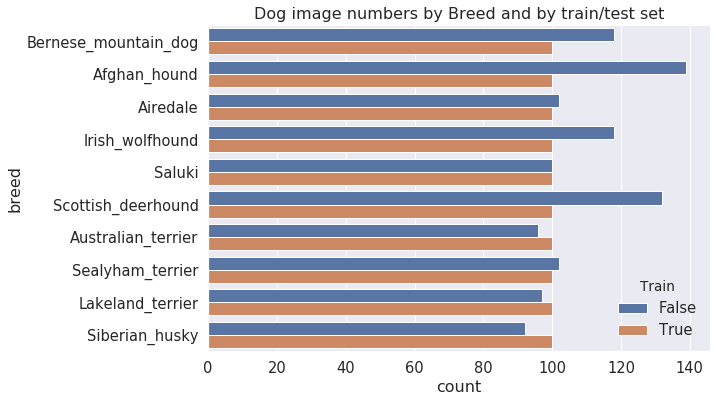

In [0]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 6))
plt.title("Dog image numbers by Breed and by train/test set")
ax = sns.countplot(y="breed", hue="Train", data=df_dogs)

## My Neural Network re-trained with data augmentation



### Features

In [0]:
nb_breeds

3

In [0]:
X_train, X_test, Y_train, Y_test, lb = create_separate_features(df_dogs,
  X, list_X_classes=np.array(range(nb_breeds)))
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("Y_train ", Y_train.shape)
print("Y_test ", Y_test.shape)

list_Y_classes = list(dict_breed.values())[:nb_breeds]
list_Y_classes

X_train  (300, 224, 224, 3)
X_test  (359, 224, 224, 3)
Y_train  (300, 3)
Y_test  (359, 3)


['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

### Data Augmentation

In [0]:
# create data generator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)



### From last training

Initial Weights of my model are the best weights found without data augmentation

#### 1000 Epochs (1/3)

In [0]:
best_model_name = "my_CNN_256filt_50nod_he_6"

In [0]:
# load best model

my_model = load_model(path_data + best_model_name + '.h5')
my_model.name 













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




'my_CNN_256filt_50nod_he_6'

In [0]:
X_train.shape

(300, 224, 224, 3)

In [0]:
len(X_train)/30

10.0

Epoch 1/1000
 - 9s - loss: 1.0426 - acc: 0.5200 - val_loss: 7.0773 - val_acc: 0.5376
Epoch 2/1000
 - 8s - loss: 1.1864 - acc: 0.4867 - val_loss: 7.1199 - val_acc: 0.5376
Epoch 3/1000
 - 8s - loss: 1.0592 - acc: 0.5267 - val_loss: 7.1449 - val_acc: 0.5320
Epoch 4/1000
 - 8s - loss: 1.1337 - acc: 0.5200 - val_loss: 7.1687 - val_acc: 0.5265
Epoch 5/1000
 - 8s - loss: 1.1122 - acc: 0.4900 - val_loss: 7.2066 - val_acc: 0.5265
Epoch 6/1000
 - 8s - loss: 1.1501 - acc: 0.4600 - val_loss: 7.2314 - val_acc: 0.5265
Epoch 7/1000
 - 8s - loss: 1.1139 - acc: 0.4667 - val_loss: 7.2647 - val_acc: 0.5237
Epoch 8/1000
 - 8s - loss: 1.0548 - acc: 0.5233 - val_loss: 7.2420 - val_acc: 0.5265
Epoch 9/1000
 - 8s - loss: 1.1897 - acc: 0.4533 - val_loss: 7.2757 - val_acc: 0.5265
Epoch 10/1000
 - 8s - loss: 1.0742 - acc: 0.4900 - val_loss: 7.2356 - val_acc: 0.5292
Epoch 11/1000
 - 8s - loss: 1.1126 - acc: 0.5000 - val_loss: 7.1860 - val_acc: 0.5265
Epoch 12/1000
 - 8s - loss: 1.2254 - acc: 0.4100 - val_loss: 7.

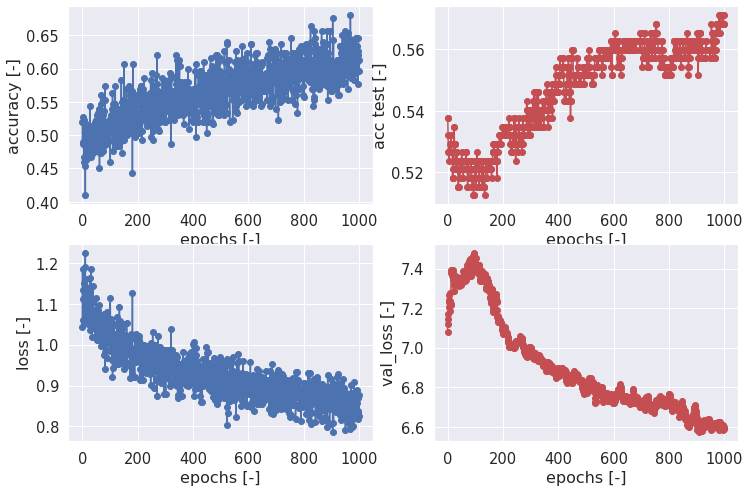

In [0]:
# Fitting parameters
epochs = 1000
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=999,
                                   restore_best_weights=True)

# fitting
t_fit_0 = time.time()
# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)
model_info = my_model.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model.save(path_data + my_model.name + '_DA.h5')

#### 1000 -> 2000 (2/3)

Epoch 1/1000
 - 8s - loss: 0.8982 - acc: 0.5400 - val_loss: 6.5947 - val_acc: 0.5682
Epoch 2/1000
 - 8s - loss: 0.8231 - acc: 0.6467 - val_loss: 6.5972 - val_acc: 0.5682
Epoch 3/1000
 - 8s - loss: 0.8420 - acc: 0.5833 - val_loss: 6.5987 - val_acc: 0.5682
Epoch 4/1000
 - 8s - loss: 0.8840 - acc: 0.5900 - val_loss: 6.6005 - val_acc: 0.5682
Epoch 5/1000
 - 8s - loss: 0.8603 - acc: 0.6200 - val_loss: 6.6089 - val_acc: 0.5682
Epoch 6/1000
 - 8s - loss: 0.8383 - acc: 0.6400 - val_loss: 6.6044 - val_acc: 0.5682
Epoch 7/1000
 - 8s - loss: 0.8638 - acc: 0.5967 - val_loss: 6.6029 - val_acc: 0.5682
Epoch 8/1000
 - 8s - loss: 0.8487 - acc: 0.6233 - val_loss: 6.6020 - val_acc: 0.5682
Epoch 9/1000
 - 8s - loss: 0.8208 - acc: 0.6267 - val_loss: 6.5823 - val_acc: 0.5682
Epoch 10/1000
 - 8s - loss: 0.8640 - acc: 0.6300 - val_loss: 6.5801 - val_acc: 0.5710
Epoch 11/1000
 - 8s - loss: 0.8507 - acc: 0.6067 - val_loss: 6.5828 - val_acc: 0.5682
Epoch 12/1000
 - 8s - loss: 0.8518 - acc: 0.5867 - val_loss: 6.

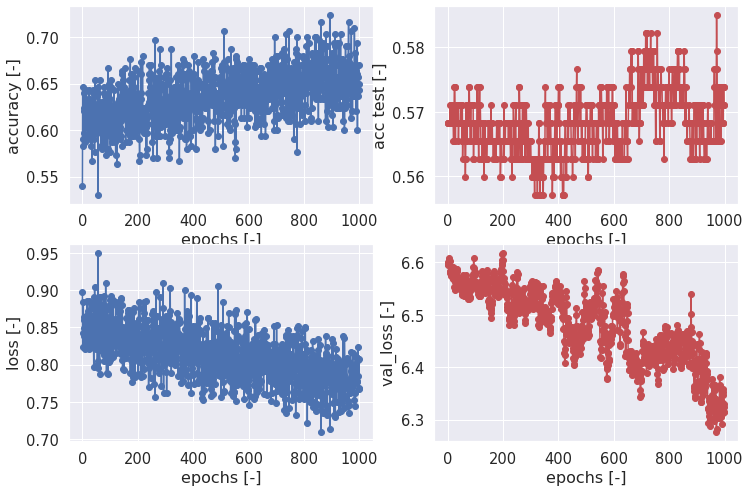

In [0]:
# Fitting parameters
epochs = 1000
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=999,
                                   restore_best_weights=True)

# fitting
t_fit_0 = time.time()
# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)
model_info = my_model.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model.save(path_data + my_model.name + '_DA_02.h5')

#### 2000 -> 3000 Epochs (3/3)

Epoch 1/1000
 - 8s - loss: 0.7370 - acc: 0.6833 - val_loss: 6.3543 - val_acc: 0.5682
Epoch 2/1000
 - 8s - loss: 0.8059 - acc: 0.6300 - val_loss: 6.3838 - val_acc: 0.5655
Epoch 3/1000
 - 8s - loss: 0.7671 - acc: 0.6700 - val_loss: 6.3956 - val_acc: 0.5655
Epoch 4/1000
 - 8s - loss: 0.8422 - acc: 0.6367 - val_loss: 6.3806 - val_acc: 0.5655
Epoch 5/1000
 - 8s - loss: 0.8173 - acc: 0.6000 - val_loss: 6.3917 - val_acc: 0.5682
Epoch 6/1000
 - 8s - loss: 0.8219 - acc: 0.6400 - val_loss: 6.3901 - val_acc: 0.5682
Epoch 7/1000
 - 8s - loss: 0.7979 - acc: 0.6500 - val_loss: 6.3793 - val_acc: 0.5682
Epoch 8/1000
 - 8s - loss: 0.7844 - acc: 0.6167 - val_loss: 6.3910 - val_acc: 0.5655
Epoch 9/1000
 - 8s - loss: 0.7299 - acc: 0.6867 - val_loss: 6.3805 - val_acc: 0.5655
Epoch 10/1000
 - 8s - loss: 0.7997 - acc: 0.6467 - val_loss: 6.3836 - val_acc: 0.5627
Epoch 11/1000
 - 8s - loss: 0.8002 - acc: 0.6600 - val_loss: 6.3776 - val_acc: 0.5655
Epoch 12/1000
 - 8s - loss: 0.7403 - acc: 0.6967 - val_loss: 6.

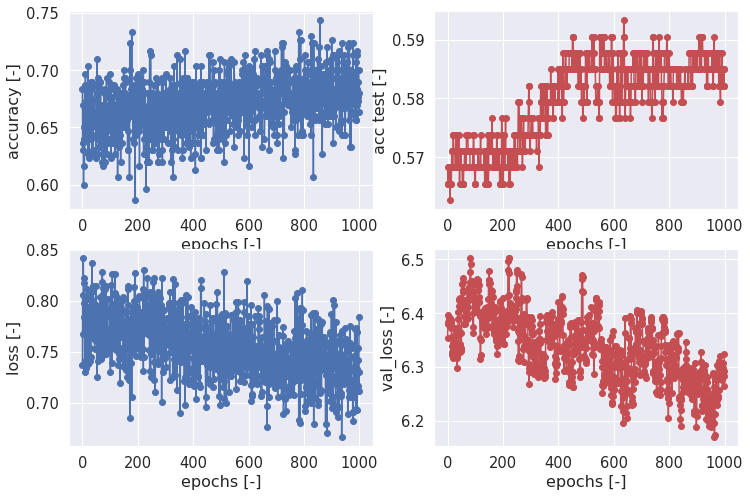

In [0]:
# Fitting parameters
epochs = 1000
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=999,
                                   restore_best_weights=True)

# fitting
t_fit_0 = time.time()
# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)
model_info = my_model.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model.save(path_data + my_model.name + '_DA_03.h5')

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
df_results 

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,t_fit,t_pred,nb_filters,nb_try
my_VGG16_02,0.512563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,12.295422,0.835936,NaN,NaN
my_VGG16_03,0.440111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667,13.711606,0.724172,NaN,NaN
my_VGG16_03_23filt,0.434540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923333,92.847607,1.958368,NaN,NaN
my_VGG16_03_24filt,0.465181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926667,91.096862,1.910622,NaN,NaN
my_VGG16_03_25filt,0.428969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903333,96.885097,2.049942,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ResNet50_TL_10b_6,0.851277,1.000000,0.884892,0.843137,0.686441,0.84,0.750000,0.895833,0.960784,0.773196,0.902174,NaN,NaN,NaN,0.996000,1339.318235,20.366774,NaN,NaN
ResNet50_TL_10b_7,0.865876,0.991525,0.935252,0.813725,0.686441,0.83,0.765152,0.937500,0.990196,0.793814,0.934783,NaN,NaN,NaN,0.994000,1868.747098,20.432234,NaN,NaN
ResNet50_TL_10b_8,0.867701,1.000000,0.892086,0.872549,0.728814,0.84,0.734848,0.968750,0.960784,0.793814,0.923913,NaN,NaN,NaN,0.993000,1652.019063,20.645281,NaN,NaN
ResNet50_TL_10b_9,0.870438,1.000000,0.899281,0.833333,0.779661,0.77,0.787879,0.927083,0.970588,0.814433,0.934783,NaN,NaN,NaN,0.993000,1478.067725,21.186466,NaN,NaN


In [0]:
# load model
my_model = load_model(path_data + best_model_name + '_DA_03.h5')













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
# Y train predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_model.predict(X_train)
t_pred_1 = time.time()

# Y test : predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_model.predict(X_test)
t_pred_3 = time.time()

# prepare results
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                  Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, 
  timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
df_results = add_score(df_results, series_scores, my_model.name)

add line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
df_results

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
my_VGG16_02,0.512563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,12.295422,0.835936
my_VGG16_03,0.440111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667,NaN,NaN,13.711606,0.724172
my_VGG16_03_23filt,0.434540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923333,NaN,NaN,92.847607,1.958368
my_VGG16_03_24filt,0.465181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926667,NaN,NaN,91.096862,1.910622
my_VGG16_03_25filt,0.428969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903333,NaN,NaN,96.885097,2.049942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ResNet50_TL_10b_7,0.865876,0.991525,0.935252,0.813725,0.686441,0.83,0.765152,0.937500,0.990196,0.793814,0.934783,NaN,NaN,NaN,0.994000,NaN,NaN,1868.747098,20.432234
ResNet50_TL_10b_8,0.867701,1.000000,0.892086,0.872549,0.728814,0.84,0.734848,0.968750,0.960784,0.793814,0.923913,NaN,NaN,NaN,0.993000,NaN,NaN,1652.019063,20.645281
ResNet50_TL_10b_9,0.870438,1.000000,0.899281,0.833333,0.779661,0.77,0.787879,0.927083,0.970588,0.814433,0.934783,NaN,NaN,NaN,0.993000,NaN,NaN,1478.067725,21.186466
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print(" df_results Saved here:\n" + path_df_results)

 df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


In [0]:
df_results.index

Index(['my_VGG16_02', 'my_VGG16_03', 'my_VGG16_03_23filt',
       'my_VGG16_03_24filt', 'my_VGG16_03_25filt', 'my_VGG16_03_26filt',
       'my_VGG16_03_27filt', 'my_VGG16_03_28filt', 'my_VGG16_03_29filt',
       'my_VGG16_03_30filt', 'my_VGG16_03_31filt', 'my_VGG16_03_32filt',
       'my_VGG16_03_33filt', 'my_VGG16_03_34filt', 'my_VGG16_03_35filt',
       'my_VGG16_03_36filt', 'my_VGG16_03_37filt', 'my_VGG16_03_38filt',
       'my_VGG16_03_39filt', 'my_VGG16_03_40filt', 'my_VGG16_03_41filt',
       'my_VGG16_03_42filt', 'my_VGG16_03_43filt', 'my_VGG16_03_44filt',
       'my_VGG16_03_45filt', 'my_VGG16_03_46filt', 'my_VGG16_03_47filt',
       'my_VGG16_03_48filt', 'my_VGG16_03_49filt', 'my_VGG16_03_50filt',
       'my_VGG16_03_51filt', 'my_VGG16_03_52filt', 'my_VGG16_03_53filt',
       'my_VGG16_03_54filt', 'my_VGG16_03_55filt', 'my_VGG16_03_56filt',
       'my_VGG16_03_57filt', 'my_VGG16_03_58filt', 'my_VGG16_03_59filt',
       'my_VGG16_03_60filt', 'my_VGG16_03_61filt', 'my_VGG16_03_6

#### Conclusion

Best model my_CNN_256filt_50nod_he_6 have been improve from 53.5% to 58.5 %



#### Compare

In [0]:
df_res = df_results.filter(items=['vgg16', 'VGG16_TL_class_01', 'resnet50', 
                         "ResNet50_TL_class_01",
                         'my_CNN_256filt_50nod_he_6', 
                         'my_CNN_256filt_50nod_he_6_DA'], axis=0)
df_res

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
vgg16,0.885794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.940678,0.863309,0.852941,0.883333,NaN,NaN,0.000000,6.288219
VGG16_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.971223,0.990196,0.983333,NaN,NaN,36.452183,1.886233
resnet50,0.930362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.949153,0.920863,0.921569,0.923333,NaN,NaN,0.000000,1.548604
ResNet50_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.964029,1.000000,0.996667,NaN,NaN,31.100259,3.201744
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_6_DA,0.584958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593220,0.561151,0.607843,0.800000,NaN,NaN,7915.237841,3.998597


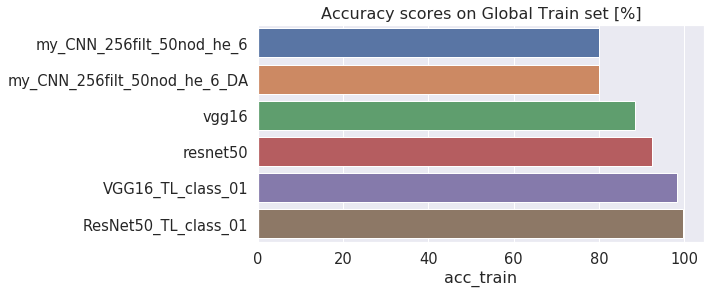

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_train").index,
    x=100*df_res.sort_values(by="acc_train")["acc_train"], orient="h")

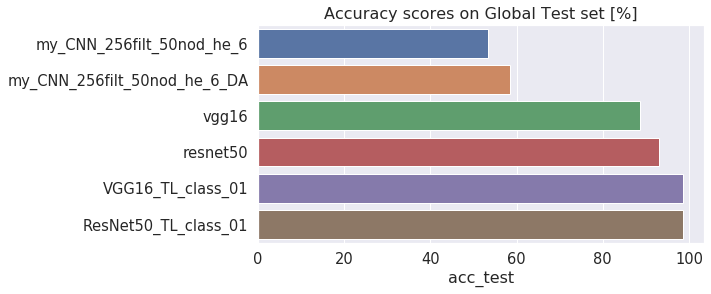

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_test").index,
    x=100*df_res.sort_values(by="acc_test")["acc_test"], orient="h")

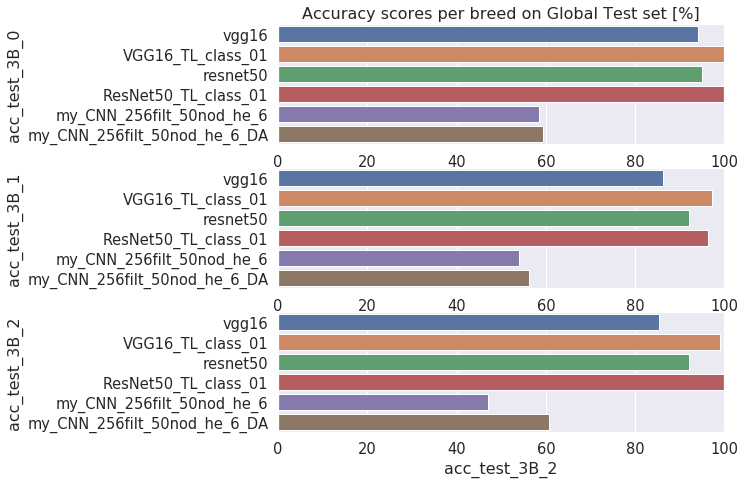

In [0]:
# plot Accuracy scores per breed on Global Test set

fig, arr_ax = plt.subplots(nb_breeds,1)
fig.set_size_inches([8, nb_breeds*25/10])
arr_ax[0].set_title("Accuracy scores per breed on Global Test set [%]")
for id in range(0,nb_breeds):
  label_curr = "acc_test_{}B_{}".format(nb_breeds, id)
  sns.barplot(ax=arr_ax[id], y=df_res.index,
      x=100*df_res[label_curr], orient="h")
  arr_ax[id].set_ylabel(label_curr)
  arr_ax[id].set_xlim([0,100])
  
 


#### Confusion matrix

In [0]:
list_Y_classes

['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

In [0]:
Y_test_pred = my_model.predict(X_test)
Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
Y_test_num = np.argmax(Y_test, axis=1)
# Confusion Matrix and Classification Report
target_names = np.array(list_Y_classes)
target_names = target_names[np.unique(np.array(np.concatenate((
    Y_test_pred_num, Y_test_num))))]
print(classification_report(Y_test_num, Y_test_pred_num, 
                            target_names=target_names))

np.set_printoptions(precision=2)

                      precision    recall  f1-score   support

Bernese_mountain_dog       0.65      0.59      0.62       118
        Afghan_hound       0.59      0.56      0.58       139
            Airedale       0.52      0.61      0.56       102

            accuracy                           0.58       359
           macro avg       0.59      0.59      0.59       359
        weighted avg       0.59      0.58      0.59       359



Normalized confusion matrix
[[0.59 0.24 0.17]
 [0.17 0.56 0.27]
 [0.14 0.25 0.61]]


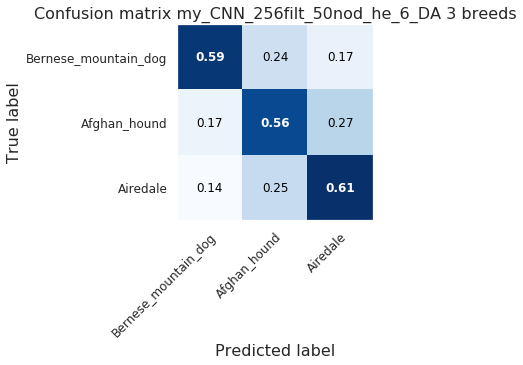

In [0]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
                            normalize=True,
  title='Confusion matrix {} 3 breeds'.format(my_model.name), size=8,
   fontsize=12)
#ax.set_ylim([nb_breeds-0.5,-0.5]);

### From scratch

Initial weights of my model are randomized from scratch

#### First run 3000 epochs

In [0]:
## My Neural Network re-trained with data augmentation (from scratch)
my_model_name = "my_CNN_256filt_50nod_he_6_DA0"



Model: "my_CNN_256filt_50nod_he_6_DA0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 802816)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                40140850  
_________________________________________________________________
dense_2 (Dense)              (None, 

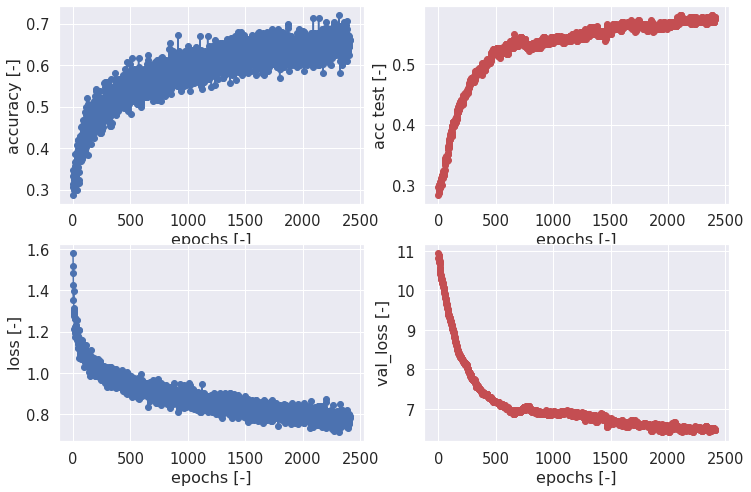

In [0]:
# initializers 
init_he_n = keras.initializers.he_normal(seed=None)
init_glorot_u = keras.initializers.glorot_uniform(seed=None)

# Model parameters
nb_filters = 256 # fixed nb filters
nb_nodes = 50 # first FC layer
conv_init = init_he_n # Conv2D layers
dens_init = init_he_n # First FC Dense layer
out_init = init_glorot_u # Output FC Dense layer

# Hyper-parameters
lr = 3e-8
decay = 1e-6
momentum = 0.9
nesterov = True 

# Fitting parameters
epochs = 3000
patience = 400
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=patience,
                                   restore_best_weights=True)

# Model creation ###
my_model_0 = Sequential()  # Création d'un réseau de neurones vide 
my_model_0.name = my_model_name

# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_model_0.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                       input_shape=(224, 224, 3),
                       padding='same', activation='relu',
                       kernel_initializer=conv_init))
# max-pooling layer
my_model_0.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_model_0.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                       activation='relu',
                       kernel_initializer=conv_init))

# Ajout de la première couche de pooling
my_model_0.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test

# flatten layer
my_model_0.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_model_0.add(Dense(nb_nodes, activation='relu',
                  kernel_initializer=dens_init))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_model_0.add(Dense(nb_breeds, activation='softmax',
                kernel_initializer=out_init))
print(my_model_0.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, nesterov=nesterov) 
# compile model
my_model_0.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                 metrics=["accuracy"])

# fitting
t_fit_0 = time.time()
model_info = my_model_0.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
                          
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model_0.save(path_data + my_model_0.name + '.h5')

In [0]:
# re-load model
my_model_0 = load_model(path_data + my_model_name + '.h5')

In [0]:
my_model_0

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
my_model_0.name

'my_CNN_256filt_50nod_he_6_DA0'

In [0]:
# Y train predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_model_0.predict(X_train)
t_pred_1 = time.time()

# Y test : predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_model_0.predict(X_test)
t_pred_3 = time.time()

# prepare results
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                  Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, 
  timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
df_results = add_score(df_results, series_scores, my_model_0.name)

add line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
df_results

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
my_VGG16_02,0.512563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,12.295422,0.835936
my_VGG16_03,0.440111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667,NaN,NaN,13.711606,0.724172
my_VGG16_03_23filt,0.434540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923333,NaN,NaN,92.847607,1.958368
my_VGG16_03_24filt,0.465181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926667,NaN,NaN,91.096862,1.910622
my_VGG16_03_25filt,0.428969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903333,NaN,NaN,96.885097,2.049942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ResNet50_TL_10b_8,0.867701,1.0,0.892086,0.872549,0.728814,0.84,0.734848,0.968750,0.960784,0.793814,0.923913,NaN,NaN,NaN,0.993000,NaN,NaN,1652.019063,20.645281
ResNet50_TL_10b_9,0.870438,1.0,0.899281,0.833333,0.779661,0.77,0.787879,0.927083,0.970588,0.814433,0.934783,NaN,NaN,NaN,0.993000,NaN,NaN,1478.067725,21.186466
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_6_DA,0.584958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593220,0.561151,0.607843,0.800000,NaN,NaN,7915.237841,3.998597


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print(" df_results Saved here:\n" + path_df_results)

 df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### 2nd run (3000 -> 4000 epochs)

In [0]:
my_model_name

'my_CNN_256filt_50nod_he_6_DA0'

Epoch 1/1000
 - 9s - loss: 0.7340 - acc: 0.7000 - val_loss: 6.4416 - val_acc: 0.5682
Epoch 2/1000
 - 8s - loss: 0.8222 - acc: 0.6433 - val_loss: 6.4737 - val_acc: 0.5710
Epoch 3/1000
 - 8s - loss: 0.8111 - acc: 0.6200 - val_loss: 6.4713 - val_acc: 0.5682
Epoch 4/1000
 - 8s - loss: 0.7970 - acc: 0.6733 - val_loss: 6.4848 - val_acc: 0.5682
Epoch 5/1000
 - 8s - loss: 0.7883 - acc: 0.6433 - val_loss: 6.4885 - val_acc: 0.5682
Epoch 6/1000
 - 8s - loss: 0.7653 - acc: 0.6733 - val_loss: 6.4781 - val_acc: 0.5682
Epoch 7/1000
 - 8s - loss: 0.7549 - acc: 0.6433 - val_loss: 6.4660 - val_acc: 0.5710
Epoch 8/1000
 - 8s - loss: 0.8264 - acc: 0.6167 - val_loss: 6.4536 - val_acc: 0.5710
Epoch 9/1000
 - 8s - loss: 0.7881 - acc: 0.6633 - val_loss: 6.4268 - val_acc: 0.5710
Epoch 10/1000
 - 8s - loss: 0.7964 - acc: 0.6633 - val_loss: 6.4236 - val_acc: 0.5710
Epoch 11/1000
 - 8s - loss: 0.7676 - acc: 0.6600 - val_loss: 6.3949 - val_acc: 0.5738
Epoch 12/1000
 - 8s - loss: 0.7810 - acc: 0.6633 - val_loss: 6.

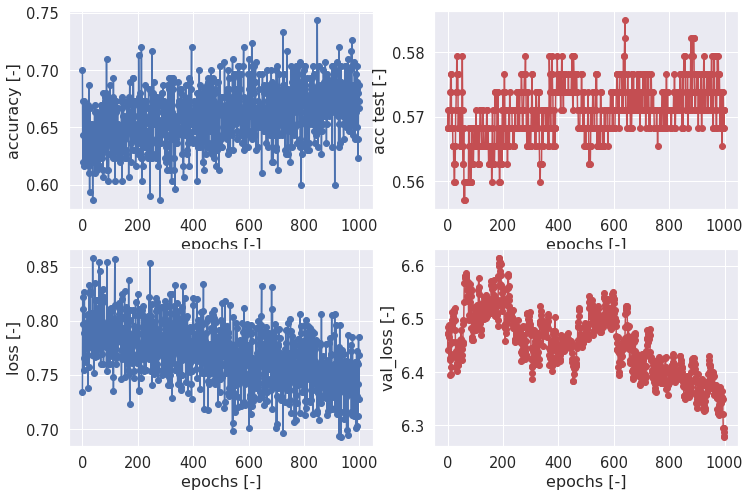

In [0]:
# Fitting parameters
epochs = 1000
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=999,
                                   restore_best_weights=True)

# fitting
t_fit_0 = time.time()
# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)
model_info = my_model_0.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model_0.save(path_data + my_model_name + '_02.h5')

In [0]:
# Y train predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_model_0.predict(X_train)
t_pred_1 = time.time()

# Y test : predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_model_0.predict(X_test)
t_pred_3 = time.time()

# prepare results
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                  Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, 
  timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
df_results = add_score(df_results, series_scores, my_model_0.name)

update line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
df_results

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
my_VGG16_02,0.512563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,12.295422,0.835936
my_VGG16_03,0.440111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667,NaN,NaN,13.711606,0.724172
my_VGG16_03_23filt,0.434540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923333,NaN,NaN,92.847607,1.958368
my_VGG16_03_24filt,0.465181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926667,NaN,NaN,91.096862,1.910622
my_VGG16_03_25filt,0.428969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903333,NaN,NaN,96.885097,2.049942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ResNet50_TL_10b_8,0.867701,1.0,0.892086,0.872549,0.728814,0.84,0.734848,0.968750,0.960784,0.793814,0.923913,NaN,NaN,NaN,0.993000,NaN,NaN,1652.019063,20.645281
ResNet50_TL_10b_9,0.870438,1.0,0.899281,0.833333,0.779661,0.77,0.787879,0.927083,0.970588,0.814433,0.934783,NaN,NaN,NaN,0.993000,NaN,NaN,1478.067725,21.186466
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_6_DA,0.584958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593220,0.561151,0.607843,0.800000,NaN,NaN,7915.237841,3.998597


In [0]:
# save results
joblib.dump(df_results, path_df_results, compress=True)
print(" df_results Saved here:\n" + path_df_results)

 df_results Saved here:
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/df_results.pkl


#### 3rd run (4000 -> 5000 epochs)

In [0]:
my_model_name = "my_CNN_256filt_50nod_he_6_DA0"

In [0]:

last_model_name =  my_model_name + '_02'
print("Load " + path_data + last_model_name + '.h5')
my_model_0 = load_model(path_data + last_model_name + '.h5')

Load /content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/my_CNN_256filt_50nod_he_6_DA0_02.h5


Epoch 1/1000
 - 18s - loss: 0.7866 - acc: 0.6500 - val_loss: 6.3216 - val_acc: 0.5710
Epoch 2/1000
 - 8s - loss: 0.7329 - acc: 0.6767 - val_loss: 6.3355 - val_acc: 0.5710
Epoch 3/1000
 - 8s - loss: 0.7366 - acc: 0.7000 - val_loss: 6.3467 - val_acc: 0.5682
Epoch 4/1000
 - 8s - loss: 0.8033 - acc: 0.6367 - val_loss: 6.3431 - val_acc: 0.5738
Epoch 5/1000
 - 8s - loss: 0.7906 - acc: 0.6667 - val_loss: 6.3538 - val_acc: 0.5710
Epoch 6/1000
 - 8s - loss: 0.7639 - acc: 0.6467 - val_loss: 6.3562 - val_acc: 0.5710
Epoch 7/1000
 - 8s - loss: 0.7003 - acc: 0.6967 - val_loss: 6.3422 - val_acc: 0.5710
Epoch 8/1000
 - 8s - loss: 0.7148 - acc: 0.7000 - val_loss: 6.3426 - val_acc: 0.5682
Epoch 9/1000
 - 8s - loss: 0.7276 - acc: 0.6567 - val_loss: 6.3389 - val_acc: 0.5710
Epoch 10/1000
 - 8s - loss: 0.7368 - acc: 0.6833 - val_loss: 6.3551 - val_acc: 0.5738
Epoch 11/1000
 - 8s - loss: 0.7415 - acc: 0.6433 - val_loss: 6.3590 - val_acc: 0.5738
Epoch 12/1000
 - 8s - loss: 0.7774 - acc: 0.6700 - val_loss: 6

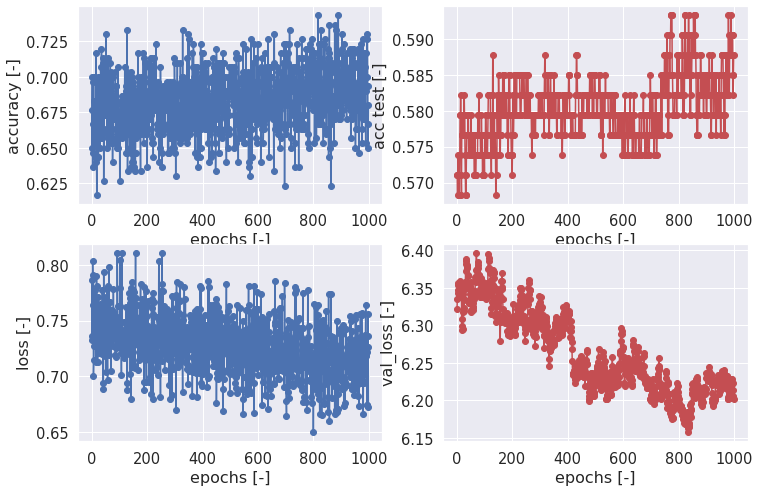

In [0]:
# Fitting parameters
epochs = 1000
batch_size = 30 # to have a integer value  because X_train = 300 
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                   verbose=1, patience=999,
                                   restore_best_weights=True)

# fitting
t_fit_0 = time.time()
# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)
model_info = my_model_0.fit_generator(datagen.flow(X_train, Y_train, 
                                                 batch_size=batch_size),
  steps_per_epoch=len(X_train) / batch_size,
  epochs=epochs, verbose=2,
  validation_data=(X_test, Y_test),
  callbacks=[es])
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model_0.save(path_data + my_model_name + '_03.h5')

In [0]:
print("Loading from disk df_results...")
df_results = joblib.load(path_df_results)

Loading from disk df_results...


In [0]:
my_model_0.name

'my_CNN_256filt_50nod_he_6_DA0'

In [0]:
print("Loading : \n" + path_data + my_model_name + '_03.h5')
my_model_0 = load_model(path_data + my_model_name + '_03.h5')

Loading : 
/content/drive/My Drive/OpenClassRooms/IML_Projet_6/data/my_CNN_256filt_50nod_he_6_DA0_03.h5


In [0]:
# Y train predict as binary labels
t_pred_0 = time.time()
Y_train_pred = my_model_0.predict(X_train)
t_pred_1 = time.time()

# Y test : predict as binary labels
t_pred_2 = time.time()
Y_test_pred = my_model_0.predict(X_test)
t_pred_3 = time.time()

# prepare results
series_scores = evaluate_mdl_scorings(Y_train, Y_train_pred, 
                                  Y_test, Y_test_pred, 
  timing_fit=t_fit_1 - t_fit_0, 
  timing_pred=t_pred_3-t_pred_2+t_pred_1-t_pred_0)
df_results = add_score(df_results, series_scores, my_model_0.name)

update line


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [0]:
df_results

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
my_VGG16_02,0.512563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,12.295422,0.835936
my_VGG16_03,0.440111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.866667,NaN,NaN,13.711606,0.724172
my_VGG16_03_23filt,0.434540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.923333,NaN,NaN,92.847607,1.958368
my_VGG16_03_24filt,0.465181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.926667,NaN,NaN,91.096862,1.910622
my_VGG16_03_25filt,0.428969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903333,NaN,NaN,96.885097,2.049942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ResNet50_TL_10b_8,0.867701,1.0,0.892086,0.872549,0.728814,0.84,0.734848,0.968750,0.960784,0.793814,0.923913,NaN,NaN,NaN,0.993000,NaN,NaN,1652.019063,20.645281
ResNet50_TL_10b_9,0.870438,1.0,0.899281,0.833333,0.779661,0.77,0.787879,0.927083,0.970588,0.814433,0.934783,NaN,NaN,NaN,0.993000,NaN,NaN,1478.067725,21.186466
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_6_DA,0.584958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593220,0.561151,0.607843,0.800000,NaN,NaN,7915.237841,3.998597


### Compare

In [0]:
df_res = df_results.filter(items=['vgg16', 'VGG16_TL_class_01', 'resnet50', 
                         "ResNet50_TL_class_01",
                         'my_CNN_256filt_50nod_he_6', 
                         'my_CNN_256filt_50nod_he_6_DA',
                         'my_CNN_256filt_50nod_he_6_DA0'], axis=0)
df_res

,acc_test,acc_test_10B_0,acc_test_10B_1,acc_test_10B_2,acc_test_10B_3,acc_test_10B_4,acc_test_10B_5,acc_test_10B_6,acc_test_10B_7,acc_test_10B_8,acc_test_10B_9,acc_test_3B_0,acc_test_3B_1,acc_test_3B_2,acc_train,nb_filters,nb_try,t_fit,t_pred
vgg16,0.885794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.940678,0.863309,0.852941,0.883333,NaN,NaN,0.000000,6.288219
VGG16_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.971223,0.990196,0.983333,NaN,NaN,36.452183,1.886233
resnet50,0.930362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.949153,0.920863,0.921569,0.923333,NaN,NaN,0.000000,1.548604
ResNet50_TL_class_01,0.986072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.964029,1.000000,0.996667,NaN,NaN,31.100259,3.201744
my_CNN_256filt_50nod_he_6,0.534819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584746,0.539568,0.470588,0.800000,256.0,6.0,223.203674,1.394404
my_CNN_256filt_50nod_he_6_DA,0.584958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.593220,0.561151,0.607843,0.800000,NaN,NaN,7915.237841,3.998597
my_CNN_256filt_50nod_he_6_DA0,0.587744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.610169,0.489209,0.696078,0.720000,NaN,NaN,7880.063367,7.212410


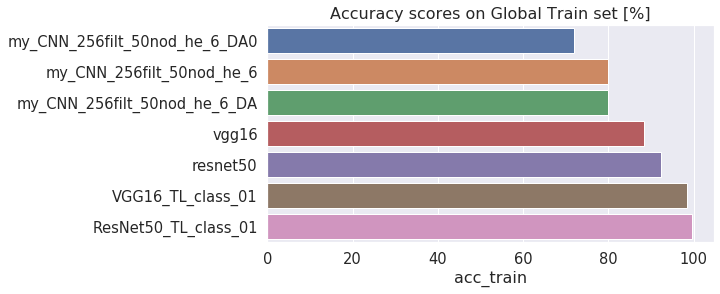

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Train set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_train").index,
    x=100*df_res.sort_values(by="acc_train")["acc_train"], orient="h")

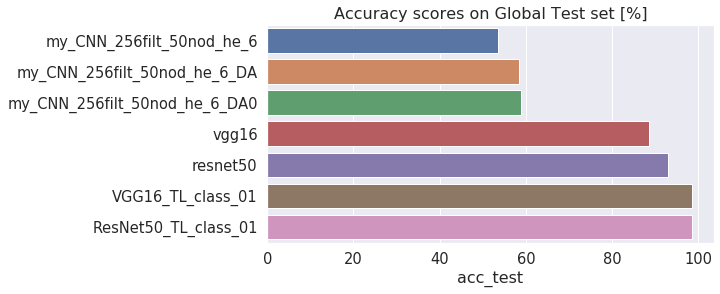

In [0]:
fig = plt.figure(figsize=(8, 4))
plt.title("Accuracy scores on Global Test set [%]")
ax = sns.barplot(
    y=df_res.sort_values(by="acc_test").index,
    x=100*df_res.sort_values(by="acc_test")["acc_test"], orient="h")

In [0]:
list_Y_classes

['Bernese_mountain_dog', 'Afghan_hound', 'Airedale']

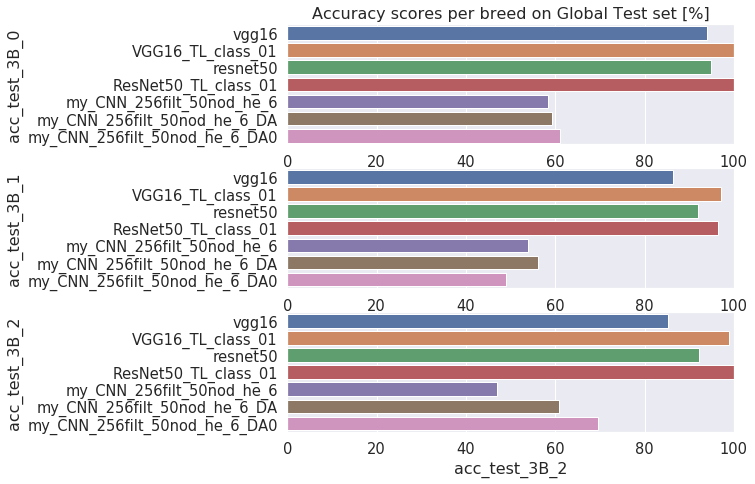

In [0]:
# plot Accuracy scores per breed on Global Test set

fig, arr_ax = plt.subplots(nb_breeds,1)
fig.set_size_inches([8, nb_breeds*25/10])
arr_ax[0].set_title("Accuracy scores per breed on Global Test set [%]")
for id in range(0,nb_breeds):
  label_curr = "acc_test_{}B_{}".format(nb_breeds, id)
  sns.barplot(ax=arr_ax[id], y=df_res.index,
      x=100*df_res[label_curr], orient="h")
  arr_ax[id].set_ylabel(label_curr)
  arr_ax[id].set_xlim([0,100])
  
 


#### Confusion matrix

In [0]:
Y_test_pred = my_model_0.predict(X_test)
Y_test_pred_num = np.argmax(Y_test_pred, axis=1)
Y_test_num = np.argmax(Y_test, axis=1)
# Confusion Matrix and Classification Report
target_names = np.array(list_Y_classes)
target_names = target_names[np.unique(np.array(np.concatenate((
    Y_test_pred_num, Y_test_num))))]
print(classification_report(Y_test_num, Y_test_pred_num, 
                            target_names=target_names))

np.set_printoptions(precision=2)

                      precision    recall  f1-score   support

Bernese_mountain_dog       0.63      0.61      0.62       118
        Afghan_hound       0.61      0.49      0.54       139
            Airedale       0.54      0.70      0.61       102

            accuracy                           0.59       359
           macro avg       0.59      0.60      0.59       359
        weighted avg       0.59      0.59      0.59       359



Normalized confusion matrix
[[0.61 0.23 0.16]
 [0.21 0.49 0.3 ]
 [0.14 0.17 0.7 ]]


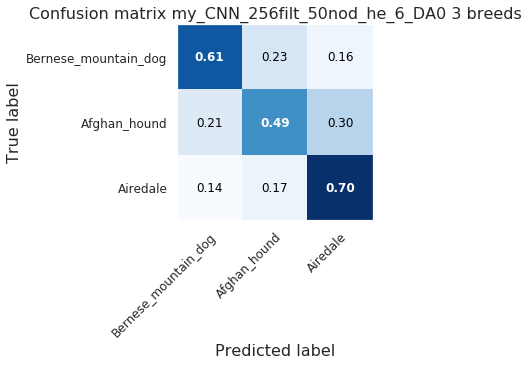

In [0]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
  normalize=True,
  title='Confusion matrix {} 3 breeds'.format(my_model_0.name), size=8,
   fontsize=12)
#ax.set_ylim([nb_breeds-0.5,-0.5]);

#### 3rd run (1000 epochs with TPU) : DOESNT WORK

In [0]:
## My Neural Network re-trained with data augmentation (from scratch)
my_model_name = "my_CNN_256filt_50nod_he_6_DA0"

In [0]:
last_model_name = "my_CNN_256filt_50nod_he_6_DA0_02"
my_model_0.save(path_data + my_model_name + '_02.h5')
my_model = load_model(path_data + last_model_name + '.h5')

In [0]:
es

In [0]:
# load weights
# load last model
with strategy.scope():
  last_model_name = "my_CNN_256filt_50nod_he_6_DA0_02"
  my_model = load_model(path_data + last_model_name + '.h5', compile=False)
  #my_model.save_weights(path_data + last_model_name + '_weights.h5')


InvalidArgumentError: ignored

In [0]:
del my_model_0

In [0]:
# Hyper-parameters
lr = 3e-8
decay = 1e-6
momentum = 0.9
nesterov = True 

# Fitting parameters
epochs = 3
batch_size = 30 # to have a integer value  because X_train = 300 

# Model creation into TPU strategy ###
#with strategy.scope():

# initializers 
init_he_n = keras.initializers.he_normal(seed=None)
init_glorot_u = keras.initializers.glorot_uniform(seed=None)

# Model parameters
nb_filters = 256 # fixed nb filters
nb_nodes = 50 # first FC layer
conv_init = init_he_n # Conv2D layers
dens_init = init_he_n # First FC Dense layer
out_init = init_glorot_u # Output FC Dense layer

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                  verbose=1, patience=999,
                                  restore_best_weights=True)
my_model_0 = Sequential()  # Création d'un réseau de neurones vide 
my_model_0.name = my_model_name

# Ajout de la première couche de convolution, suivie d'une couche ReLU
my_model_0.add(Conv2D(nb_filters, kernel_size=3, strides=1, 
                      input_shape=(224, 224, 3),
                      padding='same', activation='relu'))
# max-pooling layer
my_model_0.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test
# Ajout de la deuxième couche de convolution, suivie  d'une couche ReLU
my_model_0.add(Conv2D(nb_filters, kernel_size=3, strides=1, padding='same', 
                      activation='relu'))

# Ajout de la première couche de pooling
my_model_0.add(MaxPooling2D(pool_size=(2,2), strides=(2,2))) # test

# flatten layer
my_model_0.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
my_model_0.add(Dense(nb_nodes, activation='relu'))

# Ajout de la dernière couche fully-connected qui permet de classifier
my_model_0.add(Dense(nb_breeds, activation='softmax'))


# load last weights
#my_model_0.load_weights(path_data + last_model_name + '_weights.h5')

# summary
print(my_model_0.summary())

# optimizer
sgd_2 = optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                        nesterov=nesterov) 
# compile model
my_model_0.compile(loss="categorical_crossentropy", optimizer=sgd_2, 
                metrics=["accuracy"])



Model: "my_CNN_256filt_50nod_he_6_DA0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 802816)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                40140850  
_________________________________________________________________
dense_2 (Dense)              (None, 

In [0]:

# fitting
t_fit_0 = time.time()
my_model_0.fit(X_train,  Y_train, epochs=1)
t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)

# plot results at each iterations
plot_history(model_info.history)

#  save model
my_model_0.save(path_data + my_model_name + '_03.h5')

Epoch 1/1
300/300 [==============================] - 297s 990ms/step - loss: 8.0796 - acc: 0.3333
Timing:  297.33002758026123


NameError: ignored